In [1]:
#Library Import
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot as plt

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso,Ridge
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA 
pd.set_option('display.max_rows', 500)

from scipy import stats
from bs4 import BeautifulSoup 
import requests
import json
import re
import urllib
from itertools import chain
from time import sleep
from tqdm import tqdm

# Web Scraping 

In [2]:
# Team URL Extraction
def build_team_urls():
    # Open the espn teams webpage and extract the names of each roster available.
    f = urllib.request.urlopen('http://www.espn.com/nba/teams')
    teams_source = f.read().decode('utf-8')
    teams = dict(re.findall("www\.espn\.com/nba/team/_/name/(\w+)/(.+?)\",", teams_source))
    # Using the names of the rosters, create the urls of each roster
    roster_urls = []
    for key in teams.keys():
        # each roster webpage follows this general pattern.
        roster_urls.append('http://www.espn.com/nba/team/roster/_/name/' + key + '/' + teams[key])
        teams[key] = str(teams[key])
    return dict(zip(teams.values(), roster_urls))
#Extract Players basic information
def player_info(team_url):
    f = urllib.request.urlopen(team_url)
    teams_source = f.read().decode('utf-8')
    sleep(0.5)
    player_regex = ('"athletes":(.+?)"subType":')
    player = re.findall(player_regex, teams_source)[0]
    # Convert palyers to pandas dataframe
    return pd.read_json(player[1:-4], lines=True)
#Convert height
def convert_height(h):
    split_height = h.split(' ')
    feet = float(split_height[0].replace("\'",""))
    inches = float(split_height[1].replace("\"",""))
    return (feet*12 + inches)

In [3]:
# Get Team URLs and scrape the data
team_urls = build_team_urls()
player_physical = []
for url in tqdm(team_urls.values()):
    player_physical.append(player_info(url))

100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


In [4]:
player_physical = pd.concat(player_physical)
player_physical = player_physical.reset_index(drop=True)

In [5]:
career_stats_df = pd.DataFrame(columns = ["GP","GS","MIN","FGM", "FGA","FG%","3PTM",
                                          "3PTA","3P%","FTM","FTA","FT%","OR","DR",
                                          "REB","AST","BLK","STL","PF","TO","PTS",'id'])
# Performance score
for player_index in tqdm(player_physical.index):
    url = "https://www.espn.com/nba/player/stats/_/id/" + str(player_physical.iloc[player_index]['id'])
    f = urllib.request.urlopen(url)
    sleep(0.3)
    player_source = f.read().decode('utf-8')
    # extract career stats using this regex
    stats_regex = ('\[\"Career\",\"\",(.*?)\]\},\{\"ttl\"\:\"Regular Season Totals\"')
    career_info = re.findall(stats_regex, player_source)
    try:
        # convert the stats to a list of floats, and add the entry to the DataFrame
        career_info = career_info[0].replace("\"", "").split(",")
        career_info = list(chain.from_iterable([i.split("-") for i in career_info]))
        career_info = list(map(float,career_info)) + [player_physical.iloc[player_index]['id']]
        career_stats_df = career_stats_df.append(pd.Series(career_info, index = career_stats_df.columns, name=player_index))
    except:
        # if no career stats were returned, the player was a rookie with no games played
        print(str(player_index) + " has no info, ", end = "")

  1%|          | 7/603 [00:04<06:00,  1.66it/s]

6 has no info, 

  1%|▏         | 8/603 [00:04<05:50,  1.70it/s]

7 has no info, 

  2%|▏         | 10/603 [00:05<05:55,  1.67it/s]

9 has no info, 

  3%|▎         | 21/603 [00:12<06:44,  1.44it/s]

20 has no info, 

  6%|▌         | 36/603 [00:21<05:28,  1.73it/s]

35 has no info, 

  6%|▋         | 38/603 [00:22<05:21,  1.76it/s]

37 has no info, 

  9%|▉         | 54/603 [00:32<05:24,  1.69it/s]

53 has no info, 

  9%|▉         | 55/603 [00:32<05:24,  1.69it/s]

54 has no info, 

 10%|█         | 61/603 [00:36<05:18,  1.70it/s]

60 has no info, 

 12%|█▏        | 73/603 [00:43<05:08,  1.72it/s]

72 has no info, 

 12%|█▏        | 75/603 [00:44<04:59,  1.76it/s]

74 has no info, 

 13%|█▎        | 76/603 [00:45<04:57,  1.77it/s]

75 has no info, 

 13%|█▎        | 80/603 [00:47<04:54,  1.77it/s]

79 has no info, 

 15%|█▌        | 92/603 [00:54<05:00,  1.70it/s]

91 has no info, 

 15%|█▌        | 93/603 [00:55<05:14,  1.62it/s]

92 has no info, 

 18%|█▊        | 107/603 [01:03<04:43,  1.75it/s]

106 has no info, 

 20%|█▉        | 118/603 [01:09<04:32,  1.78it/s]

117 has no info, 

 20%|██        | 123/603 [01:12<04:35,  1.74it/s]

122 has no info, 

 22%|██▏       | 133/603 [01:19<05:46,  1.36it/s]

132 has no info, 

 23%|██▎       | 137/603 [01:21<05:08,  1.51it/s]

136 has no info, 

 23%|██▎       | 140/603 [01:23<04:36,  1.68it/s]

139 has no info, 

 24%|██▎       | 142/603 [01:24<04:25,  1.74it/s]

141 has no info, 

 24%|██▍       | 144/603 [01:25<04:20,  1.76it/s]

143 has no info, 

 24%|██▍       | 145/603 [01:26<04:37,  1.65it/s]

144 has no info, 

 24%|██▍       | 146/603 [01:27<04:53,  1.56it/s]

145 has no info, 

 25%|██▌       | 151/603 [01:29<04:21,  1.73it/s]

150 has no info, 

 26%|██▌       | 154/603 [01:31<04:32,  1.65it/s]

153 has no info, 

 26%|██▌       | 155/603 [01:32<04:24,  1.69it/s]

154 has no info, 

 27%|██▋       | 162/603 [01:36<04:09,  1.77it/s]

161 has no info, 

 27%|██▋       | 163/603 [01:36<04:06,  1.79it/s]

162 has no info, 

 28%|██▊       | 168/603 [01:39<04:03,  1.79it/s]

167 has no info, 

 30%|██▉       | 179/603 [01:45<04:00,  1.76it/s]

178 has no info, 

 32%|███▏      | 190/603 [01:52<04:14,  1.62it/s]

189 has no info, 

 33%|███▎      | 198/603 [01:57<03:51,  1.75it/s]

197 has no info, 

 33%|███▎      | 200/603 [01:58<03:51,  1.74it/s]

199 has no info, 

 33%|███▎      | 201/603 [01:59<03:48,  1.76it/s]

200 has no info, 

 36%|███▌      | 217/603 [02:08<03:27,  1.86it/s]

216 has no info, 

 36%|███▌      | 218/603 [02:08<03:26,  1.86it/s]

217 has no info, 

 36%|███▋      | 219/603 [02:09<03:27,  1.85it/s]

218 has no info, 

 37%|███▋      | 224/603 [02:12<03:29,  1.81it/s]

223 has no info, 

 38%|███▊      | 227/603 [02:13<03:40,  1.71it/s]

226 has no info, 

 38%|███▊      | 228/603 [02:14<03:33,  1.75it/s]

227 has no info, 

 38%|███▊      | 229/603 [02:15<03:29,  1.79it/s]

228 has no info, 

 38%|███▊      | 230/603 [02:15<03:26,  1.80it/s]

229 has no info, 

 39%|███▉      | 237/603 [02:19<03:35,  1.70it/s]

236 has no info, 

 39%|███▉      | 238/603 [02:20<03:31,  1.72it/s]

237 has no info, 

 40%|███▉      | 240/603 [02:21<03:27,  1.75it/s]

239 has no info, 

 40%|████      | 242/603 [02:22<03:21,  1.79it/s]

241 has no info, 

 40%|████      | 244/603 [02:23<03:17,  1.82it/s]

243 has no info, 

 41%|████▏     | 250/603 [02:27<03:33,  1.65it/s]

249 has no info, 

 44%|████▎     | 263/603 [02:35<03:16,  1.73it/s]

262 has no info, 

 44%|████▍     | 266/603 [02:37<03:27,  1.63it/s]

265 has no info, 

 45%|████▍     | 271/603 [02:40<03:25,  1.62it/s]

270 has no info, 

 46%|████▌     | 276/603 [02:43<03:13,  1.69it/s]

275 has no info, 

 46%|████▋     | 280/603 [02:45<03:06,  1.74it/s]

279 has no info, 

 47%|████▋     | 281/603 [02:46<03:03,  1.75it/s]

280 has no info, 

 47%|████▋     | 283/603 [02:47<03:01,  1.77it/s]

282 has no info, 

 47%|████▋     | 285/603 [02:48<03:03,  1.73it/s]

284 has no info, 

 48%|████▊     | 291/603 [02:51<02:50,  1.83it/s]

290 has no info, 

 48%|████▊     | 292/603 [02:52<02:49,  1.84it/s]

291 has no info, 

 49%|████▉     | 294/603 [02:53<02:56,  1.75it/s]

293 has no info, 

 50%|████▉     | 301/603 [02:57<02:54,  1.73it/s]

300 has no info, 

 50%|█████     | 304/603 [02:59<02:51,  1.75it/s]

303 has no info, 

 51%|█████     | 307/603 [03:00<02:47,  1.77it/s]

306 has no info, 

 52%|█████▏    | 311/603 [03:04<04:35,  1.06it/s]

310 has no info, 

 52%|█████▏    | 314/603 [03:06<03:23,  1.42it/s]

313 has no info, 

 53%|█████▎    | 319/603 [03:09<02:46,  1.71it/s]

318 has no info, 

 53%|█████▎    | 321/603 [03:10<02:44,  1.71it/s]

320 has no info, 

 54%|█████▎    | 323/603 [03:11<02:50,  1.65it/s]

322 has no info, 

 54%|█████▍    | 327/603 [03:14<02:40,  1.72it/s]

326 has no info, 

 54%|█████▍    | 328/603 [03:14<02:36,  1.75it/s]

327 has no info, 

 55%|█████▌    | 333/603 [03:17<02:31,  1.78it/s]

332 has no info, 

 58%|█████▊    | 351/603 [03:28<02:18,  1.82it/s]

350 has no info, 

 59%|█████▉    | 358/603 [03:32<02:18,  1.76it/s]

357 has no info, 

 60%|█████▉    | 360/603 [03:33<02:16,  1.79it/s]

359 has no info, 

 60%|█████▉    | 361/603 [03:34<02:13,  1.81it/s]

360 has no info, 

 60%|██████    | 364/603 [03:35<02:20,  1.71it/s]

363 has no info, 

 62%|██████▏   | 372/603 [03:40<02:11,  1.76it/s]

371 has no info, 

 64%|██████▍   | 385/603 [03:47<02:05,  1.74it/s]

384 has no info, 

 65%|██████▍   | 391/603 [03:51<02:01,  1.75it/s]

390 has no info, 

 65%|██████▌   | 394/603 [03:53<01:56,  1.80it/s]

393 has no info, 

 67%|██████▋   | 401/603 [03:57<01:52,  1.80it/s]

400 has no info, 

 68%|██████▊   | 409/603 [04:01<02:11,  1.47it/s]

408 has no info, 

 69%|██████▉   | 415/603 [04:05<01:54,  1.64it/s]

414 has no info, 

 70%|██████▉   | 420/603 [04:08<01:48,  1.68it/s]

419 has no info, 

 70%|██████▉   | 422/603 [04:09<01:48,  1.67it/s]

421 has no info, 

 71%|███████   | 427/603 [04:12<01:45,  1.66it/s]

426 has no info, 

 71%|███████   | 428/603 [04:13<01:41,  1.72it/s]

427 has no info, 

 72%|███████▏  | 437/603 [04:18<01:32,  1.79it/s]

436 has no info, 

 73%|███████▎  | 439/603 [04:19<01:32,  1.78it/s]

438 has no info, 

 76%|███████▌  | 459/603 [04:31<01:20,  1.80it/s]

458 has no info, 

 76%|███████▋  | 461/603 [04:32<01:23,  1.71it/s]

460 has no info, 

 79%|███████▉  | 478/603 [04:42<01:10,  1.78it/s]

477 has no info, 

 81%|████████  | 486/603 [04:46<01:06,  1.77it/s]

485 has no info, 

 82%|████████▏ | 493/603 [04:50<01:01,  1.80it/s]

492 has no info, 

 82%|████████▏ | 496/603 [04:52<01:00,  1.78it/s]

495 has no info, 

 83%|████████▎ | 499/603 [04:54<00:58,  1.78it/s]

498 has no info, 

 83%|████████▎ | 500/603 [04:54<00:57,  1.80it/s]

499 has no info, 

 84%|████████▍ | 506/603 [04:58<00:55,  1.75it/s]

505 has no info, 

 84%|████████▍ | 507/603 [04:58<00:54,  1.77it/s]

506 has no info, 

 84%|████████▍ | 509/603 [04:59<00:54,  1.72it/s]

508 has no info, 

 85%|████████▌ | 515/603 [05:03<00:56,  1.55it/s]

514 has no info, 

 86%|████████▌ | 519/603 [05:06<00:54,  1.55it/s]

518 has no info, 

 88%|████████▊ | 533/603 [05:15<00:39,  1.76it/s]

532 has no info, 

 89%|████████▊ | 534/603 [05:15<00:38,  1.78it/s]

533 has no info, 

 89%|████████▉ | 538/603 [05:17<00:39,  1.66it/s]

537 has no info, 

 90%|████████▉ | 540/603 [05:19<00:47,  1.33it/s]

539 has no info, 

 90%|████████▉ | 541/603 [05:20<00:42,  1.46it/s]

540 has no info, 

 90%|█████████ | 545/603 [05:22<00:35,  1.63it/s]

544 has no info, 

 91%|█████████ | 548/603 [05:24<00:33,  1.64it/s]

547 has no info, 

 92%|█████████▏| 557/603 [05:30<00:27,  1.65it/s]

556 has no info, 

 93%|█████████▎| 560/603 [05:32<00:24,  1.72it/s]

559 has no info, 

 93%|█████████▎| 561/603 [05:32<00:23,  1.76it/s]

560 has no info, 

 93%|█████████▎| 562/603 [05:33<00:23,  1.75it/s]

561 has no info, 

 93%|█████████▎| 563/603 [05:33<00:22,  1.75it/s]

562 has no info, 

 95%|█████████▍| 572/603 [05:38<00:17,  1.78it/s]

571 has no info, 

 96%|█████████▌| 578/603 [05:42<00:15,  1.66it/s]

577 has no info, 

 96%|█████████▌| 579/603 [05:43<00:13,  1.71it/s]

578 has no info, 

 96%|█████████▌| 580/603 [05:43<00:13,  1.75it/s]

579 has no info, 

 98%|█████████▊| 592/603 [05:51<00:06,  1.65it/s]

591 has no info, 

 99%|█████████▉| 599/603 [05:55<00:02,  1.75it/s]

598 has no info, 

100%|██████████| 603/603 [05:57<00:00,  1.69it/s]


# Data Cleaning

In [6]:
player_physical = pd.merge(player_physical,career_stats_df,how = 'left',
              left_on=['id'], right_on = ['id'])

In [7]:
# Remove NA value in the columns
player_physical = player_physical[player_physical['height'].notna()]
player_physical = player_physical[player_physical['weight'].notna()]
player_physical = player_physical[player_physical['OR'].notna()]

In [8]:
# Convert the format in the dataset
player_physical['height'] = [convert_height(x) for x in player_physical['height']]
player_physical['weight'] = [float(x.split(" ")[0]) for x in player_physical['weight']]
player_physical['salary'] = [int(re.sub(r'[^\d.]+', '', s)) if isinstance(s, str) else s for s in player_physical['salary'].values]

In [9]:
# Data Import from official website
player_stats = pd.read_csv('../Datasets/nba_player_stats_official.csv')

# Average score for each player collected from espn
#player_physical = pd.read_csv('../Datasets/data_player.csv')

In [10]:
player_att = player_physical[['name','position','height','weight']]

In [11]:
# Merge with NBA official data over the years 
df = pd.merge(player_att,player_stats,how = 'left', left_on=['name'], right_on = ['PLAYER_NAME']).drop(columns = ['PLAYER_NAME']).dropna()

# EDA -  Physical Attribute and Performance

## ESPN Players Physical Attribute - Height, Weight, Age

In [12]:
# Individual Physical Attributes
physical_att = player_physical[['name','position','age','height','weight','GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']].dropna()

In [13]:
physical_att['age'].describe()

count    482.000000
mean      26.321577
std        4.011718
min       19.000000
25%       23.000000
50%       26.000000
75%       29.000000
max       40.000000
Name: age, dtype: float64

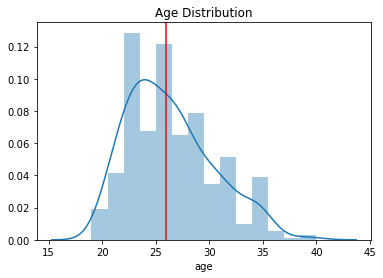

In [165]:
sns.distplot(physical_att['age'])
plt.title('Age Distribution')
plt.axvline(x=26,color='r')

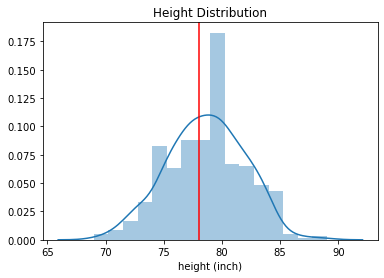

In [166]:
sns.distplot(physical_att['height'])
plt.title('Height Distribution')
plt.xlabel('height (inch)')
plt.axvline(x=78,color='r')

In [167]:
physical_att.height.describe()

count    482.000000
mean      78.601660
std        3.324926
min       69.000000
25%       76.000000
50%       79.000000
75%       81.000000
max       89.000000
Name: height, dtype: float64

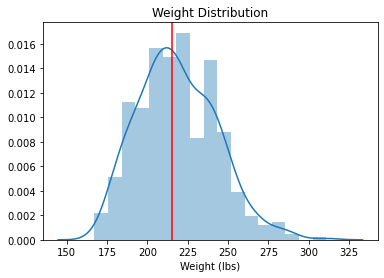

In [168]:
sns.distplot(physical_att['weight'])
plt.title('Weight Distribution')
plt.xlabel('Weight (lbs)')
plt.axvline(x=215,color='r')

In [169]:
physical_att.weight.describe()

count    482.000000
mean     218.568465
std       24.202208
min      167.000000
25%      201.000000
50%      216.000000
75%      235.000000
max      311.000000
Name: weight, dtype: float64

# Feature of Importance - Height and Weight

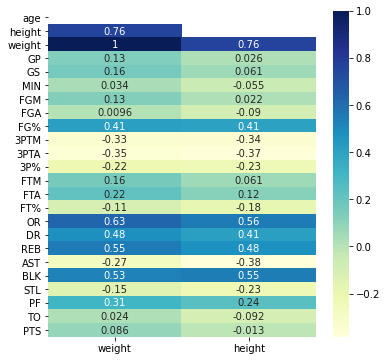

In [170]:
fig, ax = plt.subplots(figsize=(6, 6)) 
mask = np.zeros_like(physical_att.corr()[['weight','height']])
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(physical_att.corr()[['weight','height']], mask= mask, ax= ax, annot= True,cmap="YlGnBu")

## Model Fitting - Linear Regression

In [171]:
# Preparing X and y values for model fitting
X = physical_att[['height','weight']]
y = physical_att[['GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 2)

In [172]:
# Normalize the data
# mean value of the training set height and weight
m = X_train.mean()
y_m = y_train.mean()
# standard deviation of height and weight
s = X_train.std()
y_s = y_train.std()
# Normalize the training set and test set
X_train = (X_train - m) / s
X_test = (X_test - m) / s
y_train = (y_train - y_m) / y_s
y_test = (y_test - y_m) / y_s

In [173]:
# Fit linear regression models using each performance score as target variable and
#  height and weight as input variables.  
mse_test = []
mse_train =[]
perf = ['GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']
for target in perf:
    X_const = sm.add_constant(X_train)
    model = sm.OLS(y_train[target], X_train)
    res = model.fit()
    #print('\nResult Summary {0}:'.format(target))
    #_ = print(res.summary2())
    #Evaluation in the test set
    pred = res.predict(X_test)
    # Records the Test error
    mse_test.append(mean_squared_error(y_test[target], pred))
    pred = res.predict(X_train)
    # Records the Test error
    mse_train.append(mean_squared_error(y_train[target], pred))

In [175]:
# Combine Performance of each model on training set and test set
pd.DataFrame({'target':perf,'test_score':mse_test,'train_score':mse_train})

,target,test_score,train_score
0,GP,0.718287,0.962616
1,GS,0.880727,0.950857
2,MIN,1.003585,0.970934
3,FGM,1.000182,0.952841
4,FGA,0.975135,0.964873
5,FG%,0.603679,0.827934
6,3PTM,0.806204,0.866878
7,3PTA,0.774692,0.849535
8,3P%,0.907240,0.943548
9,FTM,0.911030,0.940911


## Model Detail - REB, BLK,OR
Rebounds which consist of offensive rebounds and defensive rebound, blocks have the best performance.

In [176]:
# Model Details
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['REB'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.344   
Dependent Variable:     REB              AIC:                         873.4570
Date:                   2020-12-11 15:15 BIC:                         881.2347
No. Observations:       361              Log-Likelihood:              -434.73 
Df Model:               2                F-statistic:                 95.51   
Df Residuals:           359              Prob (F-statistic):          5.51e-34
R-squared (uncentered): 0.347            Scale:                       0.65452 
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
height         0.1447        0.0626      2.3124      0.0213      0.0216      0.2677
weight         0.4751        0.0626

In [81]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['BLK'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.351   
Dependent Variable:     BLK              AIC:                         908.0003
Date:                   2020-12-07 15:31 BIC:                         915.8648
No. Observations:       377              Log-Likelihood:              -452.00 
Df Model:               2                F-statistic:                 102.9   
Df Residuals:           375              Prob (F-statistic):          2.44e-36
R-squared (uncentered): 0.354            Scale:                       0.64747 
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
height         0.3534        0.0649      5.4433      0.0000      0.2258      0.4811
weight         0.2788        0.0649

In [82]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['OR'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.447   
Dependent Variable:     OR               AIC:                         847.7860
Date:                   2020-12-07 15:31 BIC:                         855.6505
No. Observations:       377              Log-Likelihood:              -421.89 
Df Model:               2                F-statistic:                 153.1   
Df Residuals:           375              Prob (F-statistic):          2.41e-49
R-squared (uncentered): 0.450            Scale:                       0.55189 
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
height         0.2344        0.0599      3.9097      0.0001      0.1165      0.3523
weight         0.4733        0.0599

OR (Offensive rebounds per game) - R square is 0.45

REB - (rebounds per game) - R square 0.344

BLK (Block per Game) - R square 0.35

The coefficiency are positive, which means that the higher the height and heavier the weight is, players tend to have better performance on rebounds and blocks. If the player is higher, they would more likely to reach the ball in the air first. 

# NBA - How does age affect the performance?

In [177]:
player_record = player_stats.groupby(['PLAYER_NAME']).count()['AGE'].reset_index()
player_record.rename(columns={'AGE':'Exp'}, inplace=True)

With 1359 players in total, current years of experience listed. 

Text(0.5, 1.0, 'Experience Distribution')

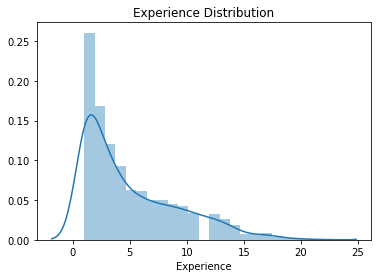

In [178]:
sns.distplot(player_record['Exp'])
plt.xlabel('Experience')
plt.title('Experience Distribution')

Players who played more than 10 years. How does the performance changes over time? 

In [179]:
# Player played more than 10 years using the official data
exp = 10
player_10 = player_record[player_record['Exp'] >= exp]
player_10 = pd.merge(player_10,player_stats,how = 'left', left_on=['PLAYER_NAME'], right_on = ['PLAYER_NAME']).dropna()

In [180]:
# (df.PTS + df.REB + df.AST + df.BLK + df.STL - (df.FGA - df.FGM) - (df.FTA - df.FTM) - df.TOV ) /GP
# NBA efficiency rating
# Reference Link: https://en.wikipedia.org/wiki/Basketball_statistics
# Data collected in already in per game format. Thus, the calculation does not divide Game played. 
def player_efficiency(df):
    return (df.PTS + df.REB + df.AST + df.BLK + df.STL - (df.FGA - df.FGM) - (df.FTA -df.FTM) - df.TOV) 

In [181]:
player_10['EFF'] = player_efficiency(player_10)

In [182]:
# Extract the first 10 records of each player played with more than 10 NBA games
player_10 = player_10.groupby(['PLAYER_NAME']).head(exp).reset_index(drop=True)

In [183]:
# Calculate the mean and median for Efficiency
med = []
avg = []
MIN_avg = [] 
for r in range(10):
    med.append(player_10[player_10['EFF'].T.index % 10 == r]['EFF'].T.describe()[5])
    avg.append(player_10[player_10['EFF'].T.index % 10 == r]['EFF'].T.describe()[1])
    MIN_avg.append(player_10[player_10['MIN'].T.index % 10 == r]['EFF'].T.describe()[1])

Text(0.5, 1.0, 'Average Efficiency')

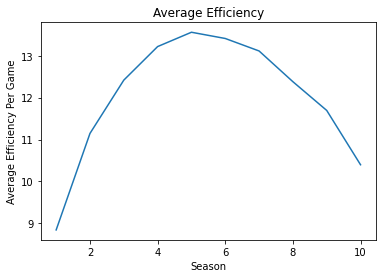

In [184]:
# Plot the average of the Effciency of the 376 players. For the past 10 years,
#   we can see that player's NBA's efficiency rating is decreasing. 
plt.plot(range(1,11,1),avg)
plt.xlabel('Season')
plt.ylabel('Average Efficiency Per Game')
plt.title('Average Efficiency')

Text(0.5, 1.0, 'Median Efficiency')

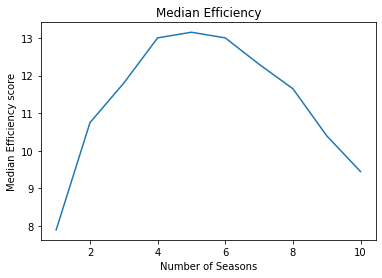

In [185]:
# Plot the median of the Effciency of the 376 players. For the past 10 years,
#   we can see that player's NBA's efficiency rating is decreasing. 
plt.plot(range(1,11,1),med)
plt.xlabel('Number of Seasons')
plt.ylabel('Median Efficiency score')
plt.title('Median Efficiency')

Text(0.5, 1.0, 'Minute Played')

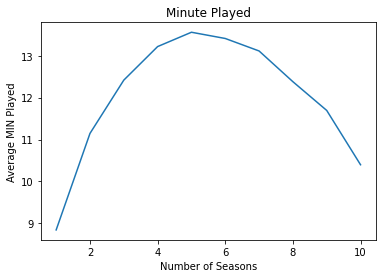

In [186]:
plt.plot(range(1,11,1),MIN_avg)
plt.xlabel('Number of Seasons')
plt.ylabel('Average MIN Played')
plt.title('Minute Played')

As we can see that that as the number of seasons played for players, they get more experience and player's efficiency will increase and peak at the fifth season. However, one of the shortage of the NBA efficiency rating is that the calculation measured heavily on the offensive performance. This measure is tied with minutes played. As the player played more, player gets more opportunities to score and potentially increase the efficiency rating. Thus, players may get under-rated 

Adjusting the rating based on the MIN played during the game

In [187]:
player_10['Adj_EFF'] = player_10['EFF'] / player_10['MIN']

In [188]:
med_adj = []
avg_adj = []
feature = 'Adj_EFF'
for r in range(10):
    med_adj.append(player_10[player_10[feature].index % 10 == r][feature].describe()[5])
    avg_adj.append(player_10[player_10[feature].index % 10 == r][feature].describe()[1])

Text(0.5, 1.0, 'Efficiency Per Minute')

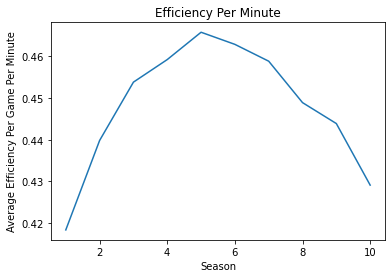

In [189]:
plt.plot(range(1,11,1),avg_adj)
plt.xlabel('Season')
plt.ylabel('Average Efficiency Per Game Per Minute')
plt.title('Efficiency Per Minute')

Efficiency adjusted by minute played shows similar trend as efficiency. 

In [190]:
five = player_10.groupby(['PLAYER_NAME']).head(5).groupby(['PLAYER_NAME']).tail(1).reset_index(drop=True)
first = player_10.groupby(['PLAYER_NAME']).head(1).reset_index(drop=True)
ten = player_10.groupby(['PLAYER_NAME']).head(10).groupby(['PLAYER_NAME']).tail(1).reset_index(drop=True)

In [191]:
# bootstrap 1000 times
def bootstrap(g1,g2,target):
    draw_perc = 0.9
    nrep = 1000 
    avg1 = []
    avg2 = []
    for i in range(nrep):
        df1 = g1.sample(frac=draw_perc, replace=True)
        df2 = g2.sample(frac=draw_perc, replace=True)
        avg1.append(df1[target].mean())
        avg2.append(df2[target].mean())
    avg1 = np.array(avg1)
    avg2 = np.array(avg2) 
    return avg1,avg2

In [192]:
# Perform two-sample t-test for first season and fifth season bootstrapped sample
m1,m2 = bootstrap(first,five,'EFF')
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=-335.6224882217597, pvalue=0.0)
4.711782840236683


The hypothesis is the average efficiency of the first and fifth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is 4.7. Thus, efficiency of the first season is lower than the efficiency of the fifth season.

In [193]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(five,ten,'EFF')
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=207.19353456302292, pvalue=0.0)
-3.1623627218934818


The hypothesis is the average efficiency of the tenth and fifth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is -3.14. Thus, average efficiency of the tenth season is lower than the efficiency of the fifth season.

Defensive Player Features:

**DREB**, **STL**, **BLK**

## Steal changes over the year

Text(0, 0.5, 'Steal Per Game')

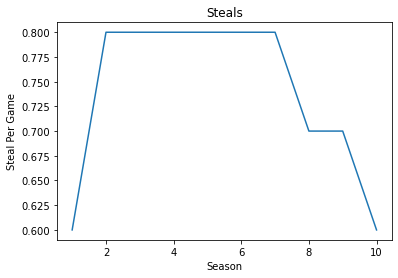

In [196]:
med_pts = []
avg_pts = []
feature = 'STL'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.title('Steals')
plt.xlabel('Season')
plt.ylabel('Steal Per Game')

In [197]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(first,five,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=-182.56703590494567, pvalue=0.0)
0.2095902366863902


The hypothesis is the average steal of the fifth and tenth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is 0.2. Thus, average steal of the first season is lower than the average steal of the fifth season.

In [195]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(five,ten,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=203.5289019791758, pvalue=0.0)
-0.2192091715976331


The hypothesis is the average steal of the fifth and tenth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is -0.21. Thus, average steal of the fifth season is higher than the average steal of the tenth season.

## Block

Text(0, 0.5, 'Block Per Game')

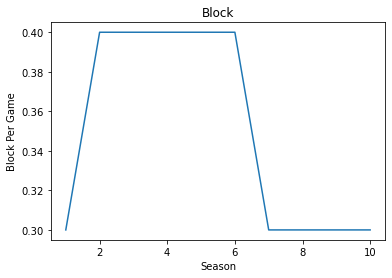

In [94]:
med_pts = []
avg_pts = []
feature = 'BLK'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.title('Block')
plt.xlabel('Season')
plt.ylabel('Block Per Game')

The data shows that after six years, the ability of block and rebounds decreases rapidly. This may due to the longer response time of the player as the age grows. 

In [198]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(first,five,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=-179.18490634249125, pvalue=0.0)
0.20802869822485173


The hypothesis is the average block of the first and fifth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is 0.20. Thus, average block of the fifth season is higher than the average  block of the first season.

In [95]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(five,ten,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=154.2079915589191, pvalue=0.0)
-0.20778816568047317


The hypothesis is the average block of the fifth and tenth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is -0.20. Thus, average block of the fifth season is higher than the average  block of the tenth season.

Text(0.5, 1.0, 'Defensive Rebounds')

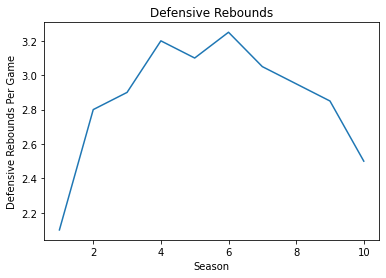

In [97]:
med_pts = []
avg_pts = []
feature = 'DREB'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.xlabel('Season')
plt.ylabel('Defensive Rebounds Per Game')
plt.title('Defensive Rebounds')

In [98]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(five,ten,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=137.09481662329435, pvalue=0.0)
-0.633453254437868


The hypothesis is the average defensive rebounds of the fifth and tenth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is -0.6. Thus, average defensive rebounds of the fifth season is lower than the average defensive rebounds of the tenth season.

In [100]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(first,five,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=-280.7754728637058, pvalue=0.0)
1.1749357988165678


The hypothesis is the average defensive rebounds of the first and fifth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is 1.17. Thus, average defensive rebounds of the fifth season is higher than the average defensive rebounds of the first season.

Text(0.5, 1.0, 'Personal Fouls')

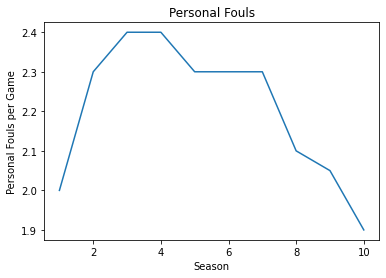

In [101]:
med_pts = []
avg_pts = []
feature = 'PF'
for r in range(10):
    med_pts.append(player_10[player_10[feature].index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.xlabel('Season')
plt.ylabel('Personal Fouls per Game')
plt.title('Personal Fouls')

In [102]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(first,five,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=-197.40500838279974, pvalue=0.0)
0.37086301775147934


The hypothesis is the average personal fouls of the first and fifth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is 0.37. Thus, average personal fouls of the fifth season is higher than the average personal fouls of the first season.

In [104]:
# Perform two-sample t-test for fifth season and tenth season
m1,m2 = bootstrap(five,ten,feature)
print(stats.ttest_ind(m1,m2))
print((m2-m1).mean())

Ttest_indResult(statistic=276.09035585285943, pvalue=0.0)
-0.45487130177514784


The hypothesis is the average personal fouls of the fifth and tenth season are the same. The p value is less than 0.05 which means we have enough evidence to reject the null hypothesis. The average difference is -0.45. Thus, average personal fouls of the fifth season is higher than the average personal fouls of the tenth season.

Personal fouls of new NBA players increase, this may have two reasons:
1. play more aggresively 
2. lack of experience

After players get more experience, The personal foul decreases over time. The reasons behind this trend could be: 
1. the players play less offensive due to fatigue.
2. Players could avoid more personal fouls based on their experience. 